In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [121]:
class CARS:
    def __init__(self,l1,l2,tp1,tp2,tp3,tmin,tmax,floor,nuR1,T21,A1):
        self.c = 2.99792e10  # speed of light [cm/s]
        self.l1 = l1
        self.l2 = l2
        self.nuR1 = nuR1
        self.tp1 = tp1
        self.tp2 = tp2
        self.tp3 = tp3
        self.tmin = tmin
        self.tmax = tmax
        self.floor = floor
        self.T21 = T21
        self.A1 = A1
        w1 = 1e7 * 2 * np.pi * self.c / self.l1
        w2 = 1e7 * 2 * np.pi * self.c / self.l2
        self.wt = w1 - w2
        wR1 = 2 * np.pi * self.nuR1 * self.c
        self.wr1 = (self.wt - wR1) * 1e-15
        self.nut = self.wt / (2 * np.pi * self.c)

    def Q_simulation_1(self):
        step = 5
        lim = 5 * self.tp1
        the = np.arange(-lim, lim, step)
        tp = np.arange(self.tmin, self.tmax, step)
        Q = np.array([np.trapz((self.A1[0]*np.exp(-(t-the)/self.T21[0]-1j*self.wr1[0]*(the))+self.A1[1]*np.exp(-(t-the)/self.T21[1]-1j*self.wr1[1]*(the)))*np.heaviside(t-the,1)*np.exp(-2*np.log(2)*((the/self.tp1)**2+(the/self.tp2)**2)))*step*1e-15 for t in tp],dtype=complex)
        return tp, Q
    
    def Q_simulation_2(self):
        step = 5
        lim = 5 * self.tp1
        the = np.arange(-lim, lim, step)
        tp = np.arange(self.tmin, self.tmax, step)
        Q = np.array([np.trapz((self.A1[0]*np.exp(-(t-the)/self.T21[0]-1j*self.wr1[0]*(t-the))+self.A1[1]*np.exp(-(t-the)/self.T21[1]-1j*self.wr1[1]*(t-the)))*np.heaviside(t-the,1)*np.exp(-2*np.log(2)*((the/self.tp1)**2+(the/self.tp2)**2)))*step*1e-15 for t in tp],dtype=complex)
        return tp, Q
    
    def CARS_simulation_1(self):
        tp, Q = self.Q_simulation_1()
        int_factor = np.sqrt(4 * np.log(2) / self.tp3**2/np.pi)
        sig = np.array([int_factor*np.trapz(np.exp(-4*np.log(2)*((t-tp)/self.tp3)**2)*np.abs(Q)**2)*5e-15 for t in tp])+self.floor
        return tp, sig
    
    def CARS_simulation_2(self):
        tp, Q = self.Q_simulation_2()
        int_factor = np.sqrt(4 * np.log(2) / self.tp3**2/np.pi)
        sig = np.array([int_factor*np.trapz(np.exp(-4*np.log(2)*((t-tp)/self.tp3)**2)*np.abs(Q)**2)*5e-15 for t in tp])+self.floor
        return tp, sig

    def CARS_simulation_FG(self):
        """
        Simulates Coherent Anti-Stokes Raman Scattering (CARS) signal
        using the frequency-gated detection method.
        """
        # ---------------------------------------------------------
        # Constants & Input Parameters
        # ---------------------------------------------------------
        norm = 1e-15  # [fs] to [s] conversion factor

        a12 = -2 * np.log(2) * (1/self.tp1**2 + 1/self.tp2**2)

        b21 = -1/self.T21 - 1j*self.wr1
        phi1 = 0

        # ---------------------------------------------------------
        # Time grid
        # ---------------------------------------------------------
        step0 = 5
        step1 = 5
        t1 = np.arange(self.tmin, self.tmax, step1)
        m1 = len(t1)

        lim = 5 * self.tp1
        ts = np.arange(-lim, lim, step0)

        Q = np.zeros(m1, dtype=complex)

        # ---------------------------------------------------------
        # Main integration loop
        # ---------------------------------------------------------
        for j1, t in enumerate(t1):

            if t < -lim:
                hs = np.zeros_like(ts)
            elif t > lim:
                hs = np.ones_like(ts)
            else:
                p1 = int(round((t + lim) / step0))
                hs = np.concatenate((np.ones(p1), np.zeros(len(ts) - p1)))
            #hs = np.heaviside(t-ts,1)
            F1 = hs * (
                self.A1[0] * np.exp(b21[0] * (t - ts) + phi1) +
                self.A1[1] * np.exp(b21[1] * (t - ts))
            ) * np.exp(a12 * ts**2)

            Q[j1] = step0 * np.trapz(F1)

        Q11 = (norm * np.abs(Q))**2

        # ---------------------------------------------------------
        # Convolution with probe pulse
        # ---------------------------------------------------------
        a3 = -4 * np.log(2) / self.tp3**2
        step2 = 5

        td = np.arange(self.tmin + 5*self.tp3, self.tmax - 5*self.tp3 + step2, step2)
        m2 = len(td)

        signal = np.zeros(m2)

        for j2 in range(m2):
            I3 = np.sqrt(-a3/np.pi) * np.exp(a3 * (t1 - td[j2])**2)
            F2 = Q11 * I3
            signal[j2] = norm * step2 * np.trapz(F2) + self.floor

        return td, signal, Q11

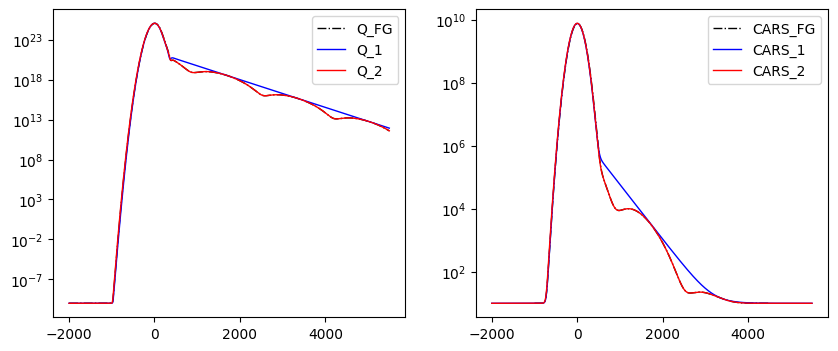

In [122]:
tdCARS = CARS(1000, 1100, 260, 260, 200, -2000, 5500, 10, np.array([750,730]), np.array([500,500]), np.array([3e25, 7e25]))
Qfloor = 1e-10
td_FG, signal_FG, Q11 = tdCARS.CARS_simulation_FG()
tp1, Q1 = tdCARS.Q_simulation_1()
tp2, Q2 = tdCARS.Q_simulation_2()
tp, signal_1 = tdCARS.CARS_simulation_1()
_, signal_2 = tdCARS.CARS_simulation_2()
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.semilogy(tp1, Q11+Qfloor, 'k-.', linewidth=1, label='Q_FG')
plt.semilogy(tp1, np.abs(Q1)**2+Qfloor, 'b-', linewidth=1, label='Q_1')
plt.semilogy(tp1, np.abs(Q2)**2+Qfloor, 'r-', linewidth=1, label='Q_2')
plt.legend()
plt.subplot(122)
plt.semilogy(td_FG, signal_FG, 'k-.', linewidth=1, label='CARS_FG')
plt.semilogy(tp, signal_1, 'b-', linewidth=1, label='CARS_1')
plt.semilogy(tp, signal_2, 'r-', linewidth=1, label='CARS_2')
plt.legend()
plt.show()

In [82]:
#detuning frequncies in THz
tdCARS.wr1

array([0.02054889, 0.02619984])

In [83]:
#tuned frequency in THz
tdCARS.wt/1e12

171.240789964544

In [84]:
#tuned frequency in 1/cm
tdCARS.nut

909.0909090909098